In [82]:
from bettools import get_data, generate_seasons, calculate_poisson_match_outcomes, calculate_ev_from_odds
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None 

In [83]:
leagues = ['E0','E1','E2','E3']#'S0','SC0','SC1','SC2','SC3','D1','D2','I1','I2','SP1','SP2','F1','F2','N1','B1','P1','T1','G1']

season_list = generate_seasons(2016, 2024)

df_ls = get_data(season_list, leagues, additional_cols=['HS','AS'])

['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'PSH', 'PSD', 'PSA', 'home_max_odds', 'away_max_odds', 'HS', 'AS']


In [84]:
main_df = pd.concat(df_ls)

home_games = main_df[['Date', 'HomeTeam', 'FTHG', 'HS']].rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals', 'HS': 'Shots'})

away_games = main_df[['Date', 'AwayTeam', 'FTAG', 'AS']].rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals', 'AS': 'Shots'})

all_games = pd.concat([home_games, away_games], ignore_index=True)

all_games.sort_values(['Team', 'Date'], inplace=True)

all_games['RollingMeanGoals'] = all_games.groupby('Team')['Goals'].transform(lambda x: x.shift().rolling(window=20).mean())
all_games['RollingMeanShots'] = all_games.groupby('Team')['Shots'].transform(lambda x: x.shift().rolling(window=20).mean())

main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals', 'RollingMeanShots']], left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanHomeGoals', 'RollingMeanShots': 'RollingMeanHomeShots'}).drop('Team', axis=1)


main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals', 'RollingMeanShots']], left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanAwayGoals', 'RollingMeanShots': 'RollingMeanAwayShots'}).drop('Team', axis=1)

main_df = main_df.dropna()

main_df.reset_index(inplace=True, drop=True)

In [85]:
total_rows = len(main_df)
split_point = int(total_rows * 0.8)

train_df = main_df.iloc[:split_point]
test_df = main_df.iloc[split_point:]

In [86]:
# For home predictions
X_home_train = train_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
y_home_train = train_df['FTHG']

X_home_test = test_df[['RollingMeanHomeGoals', 'RollingMeanHomeShots']]
y_home_test = test_df['FTHG']

# For away predictions
X_away_train = train_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
y_away_train = train_df['FTAG']

X_away_test = test_df[['RollingMeanAwayGoals', 'RollingMeanAwayShots']]
y_away_test = test_df['FTAG']

# Home model
model_home = LinearRegression()
model_home.fit(X_home_train, y_home_train)

# Away model
model_away = LinearRegression()
model_away.fit(X_away_train, y_away_train)

# Predictions for home and away
y_home_pred = model_home.predict(X_home_test)
y_away_pred = model_away.predict(X_away_test)

In [88]:
# Evaluation for home model
mse_home = mean_squared_error(y_home_test, y_home_pred)
r2_home = r2_score(y_home_test, y_home_pred)

# Evaluation for away model
mse_away = mean_squared_error(y_away_test, y_away_pred)
r2_away = r2_score(y_away_test, y_away_pred)

print("Home Model MSE:", mse_home)
print("Home Model R-squared:", r2_home)
print("Away Model MSE:", mse_away)
print("Away Model R-squared:", r2_away)

Home Model MSE: 1.45065695102035
Home Model R-squared: 0.0515811277304723
Away Model MSE: 1.2092304047266584
Away Model R-squared: 0.03295239732465227


In [89]:
test_df['PredictedFTHG'] = y_home_pred
test_df['PredictedFTAG'] = y_away_pred

In [90]:
results = test_df.apply(lambda x: calculate_poisson_match_outcomes(x['PredictedFTHG'], x['PredictedFTAG']), axis=1)

test_df['home_win_prob'], test_df['draw_prob'], test_df['away_win_prob'] = zip(*results)

<Axes: >

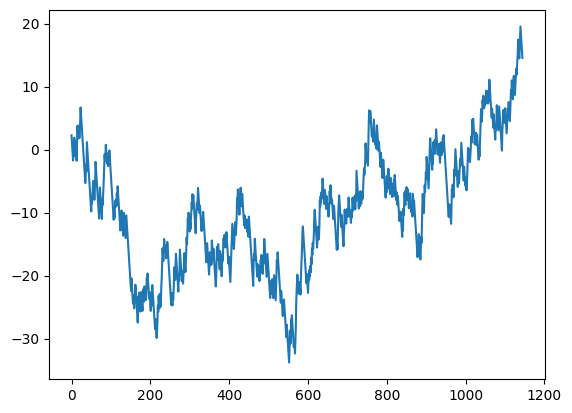

In [98]:
test_df['home_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['home_win_prob']), axis=1)
test_df['away_ev'] = test_df.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['away_win_prob']), axis=1)

HOME_MIN_THRESH = 0
HOME_MAX_THRESH = 0.5

home_bet_df = test_df[(test_df['home_ev']>HOME_MIN_THRESH)&(test_df['home_ev']<HOME_MAX_THRESH)]
home_bet_df.reset_index(inplace=True, drop=True)
home_bet_df['profit'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'], home_bet_df['home_max_odds']-1, -1)
home_bet_df['c_profit'] = home_bet_df['profit'].cumsum()
home_bet_df['c_profit'].plot()

<Axes: >

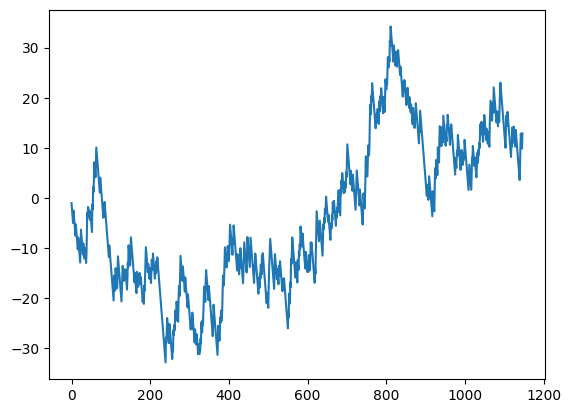

In [95]:
AWAY_MIN_THRESH = 0
AWAY_MAX_THRESH = 0.5

away_bet_df = test_df[(test_df['away_ev']>AWAY_MIN_THRESH)&(test_df['away_ev']<AWAY_MAX_THRESH)]
away_bet_df.reset_index(inplace=True, drop=True)
away_bet_df['profit'] = np.where(away_bet_df['FTAG']>away_bet_df['FTHG'], away_bet_df['away_max_odds']-1, -1)
away_bet_df['c_profit'] = away_bet_df['profit'].cumsum()
away_bet_df['c_profit'].plot()